In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
from geopandas.tools import overlay
from datetime import datetime
from shapely.geometry import shape
import pickle

In [7]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures'
root_figure_filtering = root_figure + '/Tile Filtering/'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'

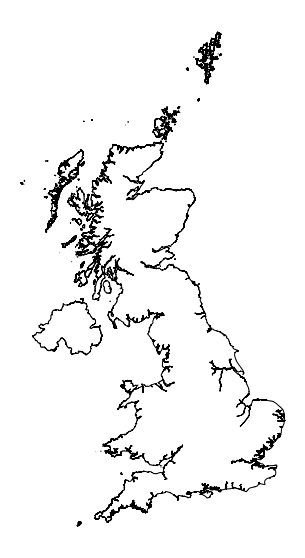

In [4]:
root = '/Users/ignaciosacristanbarba/Documents/M4R/Data'

root_map = root+'/Local_Authority_Districts__May_2020__Boundaries_UK_BGC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.shp'
root_data = root+'/BETWEEN_TILES_BASELINE.csv'

#######################
# Load map shape file #
#######################

map_df = gpd.read_file(root_map)
map_df['DUMMY'] = 1
# Dissovle to one shape
map_df2 = map_df.dissolve(by='DUMMY')
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'b'
map_df = map_df.to_crs("EPSG:3395")
map_df2 = map_df2.to_crs("EPSG:3395")

# Plot the map to show we have created boundary
f, ax = plt.subplots(1, figsize=(15, 10))
ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
ax.set_axis_off()
plt.show()

###################
# Load tiles data #
###################

df = pd.read_csv(root_data)

# Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
# adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']
# Replace nan by 0
df = df.fillna(0)
# Get the first two quadkey columns
df_key = df.iloc[:,:2]

# Now make a list of all quadkeys in the dataset (whether start or end)
quadkeys = list(set(list(df['start_quadkey'])+list(df['end_quadkey'])))
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

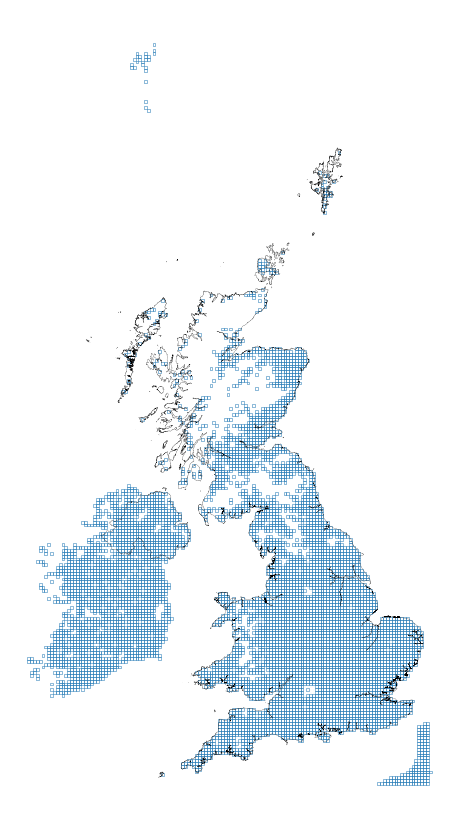

In [6]:
# Plot all quadkeys
fig, ax = plt.subplots(1, figsize=(10, 15))
ax = gdf.plot( alpha = 1, linewidth = 0.5, edgecolor='tab:blue', facecolor = 'none', ax=ax)
ax = map_df2.plot(linewidth=0.2, ax=ax, facecolor = 'none')
ax.set_axis_off()
plt.show()
fig.savefig(root_figure_filtering+'/tiles_overlay.eps', dpi=fig.dpi,bbox_inches='tight')

In [12]:
def filter_tiles(root_map,root_data):
    '''
    input: root to shape file of country, root to movement between tiles data
    output: quadkeys of tiles within boundary of country
    
    Code partially developed by Jonny
    
    '''
    
    #######################
    # Load map shape file #
    #######################
    
    map_df = gpd.read_file(root_map)
    map_df['DUMMY'] = 1
    # Dissovle to one shape
    map_df2 = map_df.dissolve(by='DUMMY')
    plt.rcParams['patch.force_edgecolor'] = True
    plt.rcParams['patch.facecolor'] = 'b'
    map_df = map_df.to_crs("EPSG:3395")
    map_df2 = map_df2.to_crs("EPSG:3395")

    # Plot the map to show we have created boundary
    f, ax = plt.subplots(1, figsize=(15, 10))
    ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
    ax.set_axis_off()
    plt.show()

    ###################
    # Load tiles data #
    ###################

    df = pd.read_csv(root_data)

    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']
    # Replace nan by 0
    df = df.fillna(0)
    # Get the first two quadkey columns
    df_key = df.iloc[:,:2]

    # Now make a list of all quadkeys in the dataset (whether start or end)
    quadkeys = list(set(list(df['start_quadkey'])+list(df['end_quadkey'])))
    polys = []

    # Iterate over all quadkeys to create corresponding polygons
    for quadkey in quadkeys:
        tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
        polys.append(tile.get('geometry'))
    geom = [shape(i) for i in polys]
    gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
    gdf = gdf.to_crs("EPSG:3395")
    
    # Plot all quadkeys
    f, ax = plt.subplots(1, figsize=(15, 10))
    ax = gdf.plot(color = 'tab:red', linewidth=0, ax=ax, edgecolor = '0.7')
    ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
    ax.set_axis_off()
    plt.show()
    
    ###################
    # Filter quadkeys #
    ###################

    # Generate a df consisting of only the quadkeys intersecting with the boundary of map
    newdf = overlay(gdf, map_df2, how="intersection")

    # Filtered df containing only those quadkeys in gdf that are within map
    gdf_filtered = gdf.loc[gdf['quadkey'].isin(newdf['quadkey'])]

    #Plot filtered quadkeys
    f, ax = plt.subplots(1, figsize=(30, 18))
    ax = gdf_filtered.plot(color = 'tab:red', linewidth=0, ax=ax, edgecolor = '0.7')
    ax = map_df2.plot(linewidth=1, ax=ax, facecolor = 'none')
    ax.set_axis_off()
    plt.show()

    ###########################
    # Store filtered quadkeys #
    ###########################

    quadkeys_filtered = list(gdf_filtered['quadkey'].astype('str'))

    # Store data (serialize)
    with open(root_results+'/Filtering'+'/quadkeys_filtered.pickle', 'wb') as handle:
        pickle.dump(quadkeys_filtered, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return quadkeys_filtered

Source for UK shape data: https://geoportal.statistics.gov.uk/datasets/local-authority-districts-may-2020-boundaries-uk-bgc?geometry=-35.833%2C46.017%2C30.964%2C63.434

In [13]:
root = '/Users/ignaciosacristanbarba/Documents/M4R/Data'

root_map = root+'/Local_Authority_Districts__May_2020__Boundaries_UK_BGC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.shp'
root_data = root+'/BETWEEN_TILES_BASELINE.csv'

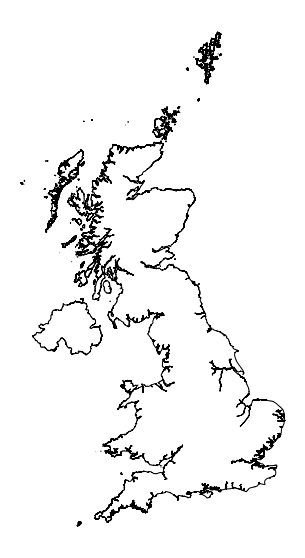

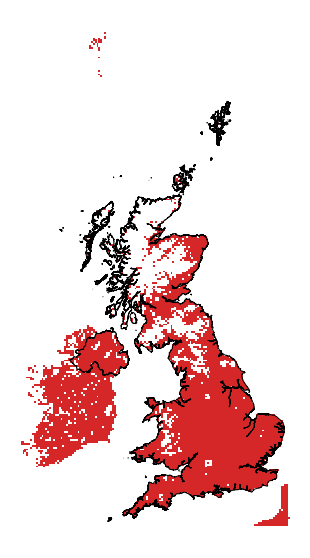

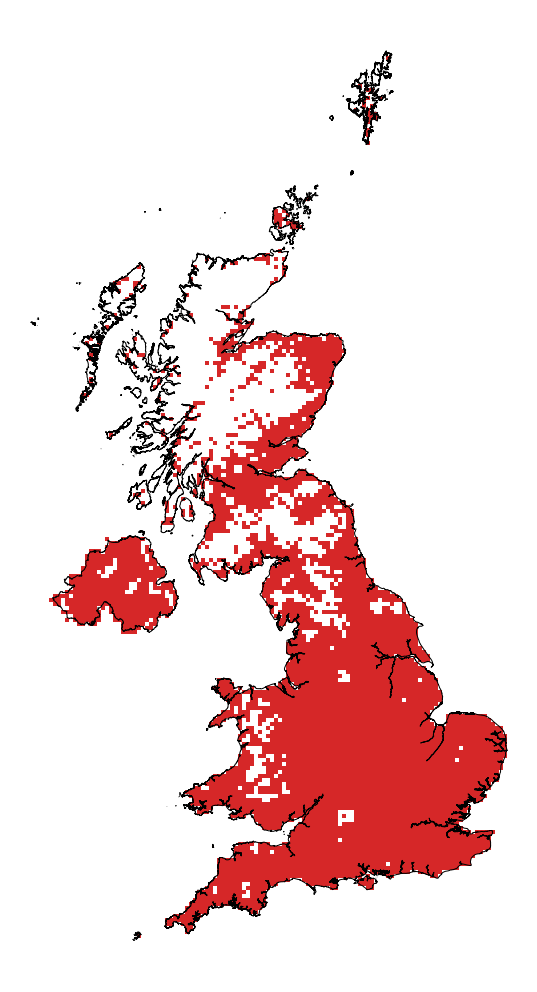

In [14]:
quadkeys_filtered_baseline = filter_tiles(root_map,root_data)

In [ ]:
root = '/Users/ignaciosacristanbarba/Documents/M4R/Data'

root_map = root+'/Local_Authority_Districts__May_2020__Boundaries_UK_BGC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.shp'
root_data = root+'/BETWEEN_TILES_TRIP_NUMBERS.csv'

quadkeys_filtered_timseries = filter_tiles(root_map,root_data)